### **Unsuccessful Mdetr Approach**

In [ ]:
# 1. Make folders
!mkdir -p data/coco
!mkdir -p data/refcocog
!mkdir -p data/my_dataset/images
!mkdir -p data/my_dataset/annotations


In [ ]:
%cd /content
# First, install the datasets library if you haven't already
!pip install datasets

from datasets import load_dataset

# Load the RefCOCOg dataset. This will download the annotations.
refcocog_dataset = load_dataset('jxu124/refcocog')

print(refcocog_dataset)

/content


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-4fe3e6340cfb69(…):   0%|          | 0.00/39.1M [00:00<?, ?B/s]

data/validation-00000-of-00001-15168dfe7(…):   0%|          | 0.00/2.31M [00:00<?, ?B/s]

data/test-00000-of-00001-2316f36b19cd7f7(…):   0%|          | 0.00/4.59M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42226 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2573 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5023 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'split', 'sentences', 'file_name', 'category_id', 'ann_id', 'sent_ids', 'ref_id', 'raw_anns', 'raw_image_info', 'raw_sentences', 'image_path', 'bbox', 'captions', 'global_image_id', 'anns_id'],
        num_rows: 42226
    })
    validation: Dataset({
        features: ['image_id', 'split', 'sentences', 'file_name', 'category_id', 'ann_id', 'sent_ids', 'ref_id', 'raw_anns', 'raw_image_info', 'raw_sentences', 'image_path', 'bbox', 'captions', 'global_image_id', 'anns_id'],
        num_rows: 2573
    })
    test: Dataset({
        features: ['image_id', 'split', 'sentences', 'file_name', 'category_id', 'ann_id', 'sent_ids', 'ref_id', 'raw_anns', 'raw_image_info', 'raw_sentences', 'image_path', 'bbox', 'captions', 'global_image_id', 'anns_id'],
        num_rows: 5023
    })
})


In [ ]:
# 2. Download COCO images + annotations
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip


--2025-08-12 18:22:45--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.99.49, 16.182.106.137, 16.182.97.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.99.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  58.6MB/s    in 3m 58s  

2025-08-12 18:26:43 (54.1 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2025-08-12 18:26:43--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.178.141, 52.217.175.121, 3.5.0.87, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.178.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.

In [ ]:
!unzip -q train2014.zip -d data/coco
!unzip -q val2014.zip -d data/coco
!unzip -q annotations_trainval2014.zip -d data/coco

### **Extracting Dataset [ coco + refcocog ]**

In [ ]:

import json, random, os, shutil
from datasets import load_dataset
from collections import defaultdict

# 1. Define paths and create directories
COCO_ANN_PATH = "data/coco/annotations/instances_train2014.json"
SRC_IMG_DIR_TRAIN = "data/coco/train2014"
SRC_IMG_DIR_VAL = "data/coco/val2014"

!mkdir -p data/my_dataset_2/annotations

MINI_DATASET_DIR = "data/my_dataset_2"
MINI_ANN_DIR = os.path.join(MINI_DATASET_DIR, "annotations")
MINI_IMG_DIR_TRAIN = os.path.join(MINI_DATASET_DIR, "train2014")
MINI_IMG_DIR_VAL = os.path.join(MINI_DATASET_DIR, "val2014")

os.makedirs(MINI_ANN_DIR, exist_ok=True)
os.makedirs(MINI_IMG_DIR_TRAIN, exist_ok=True)
os.makedirs(MINI_IMG_DIR_VAL, exist_ok=True)

# 2. Load the original datasets
with open(COCO_ANN_PATH, "r") as f:
    coco_data = json.load(f)

print("Loading RefCOCOg from Hugging Face Hub...")
refcocog_dataset = load_dataset('jxu124/refcocog')
print("RefCOCOg loaded.")

# 3. Randomly sample 1000 images

# Get all image IDs that have COCO annotations
coco_image_ids = {img['id'] for img in coco_data['images']}

# Get all image IDs that have RefCOCOg phrases
refcocog_image_ids = {ann['image_id'] for ann in refcocog_dataset['train']}

# Find the intersection of both sets
images_with_both_ids = list(coco_image_ids.intersection(refcocog_image_ids))

if len(images_with_both_ids) < 1000:
    print(f"Warning: Only {len(images_with_both_ids)} images have both annotations. Sampling all available images.")
    sample_image_ids = images_with_both_ids
else:
    random.seed(42)  # For reproducibility
    sample_image_ids = random.sample(images_with_both_ids, 1000)

sample_images = [img for img in coco_data["images"] if img["id"] in sample_image_ids]
print(f"\nSampled {len(sample_images)} images with both annotations.")

# 4. Filter annotations for the sampled images

sample_coco_annotations = [
    ann for ann in coco_data["annotations"] if ann["image_id"] in sample_image_ids
]

# Extract all RefCOCOg annotations for the sampled images
all_refcocog_annotations = []
for split in refcocog_dataset:
    all_refcocog_annotations.extend(refcocog_dataset[split])

sample_refcocog_annotations = [
    ann for ann in all_refcocog_annotations if ann["image_id"] in sample_image_ids
]

# 5. Split the mini dataset (train/val)

random.shuffle(sample_images)
val_split = int(len(sample_images) * 0.1)
val_images = sample_images[:val_split]
train_images = sample_images[val_split:]

val_image_ids = {img["id"] for img in val_images}
train_image_ids = {img["id"] for img in train_images}

train_coco_ann = [ann for ann in sample_coco_annotations if ann["image_id"] in train_image_ids]
val_coco_ann = [ann for ann in sample_coco_annotations if ann["image_id"] in val_image_ids]

train_refcocog_ann = [ann for ann in sample_refcocog_annotations if ann["image_id"] in train_image_ids]
val_refcocog_ann = [ann for ann in sample_refcocog_annotations if ann["image_id"] in val_image_ids]

# 6. Save the new annotation files

train_coco_data = {"images": train_images, "annotations": train_coco_ann, "categories": coco_data["categories"]}
val_coco_data = {"images": val_images, "annotations": val_coco_ann, "categories": coco_data["categories"]}
with open(os.path.join(MINI_ANN_DIR, "instances_train.json"), "w") as f:
    json.dump(train_coco_data, f)
with open(os.path.join(MINI_ANN_DIR, "instances_val.json"), "w") as f:
    json.dump(val_coco_data, f)

with open(os.path.join(MINI_ANN_DIR, "refcocog_train.json"), "w") as f:
    json.dump(train_refcocog_ann, f)
with open(os.path.join(MINI_ANN_DIR, "refcocog_val.json"), "w") as f:
    json.dump(val_refcocog_ann, f)

print("New COCO and RefCOCOg annotation files created.")

# 7. Copy the actual image files

for img in sample_images:
    file_name = img["file_name"]
    src_path_train = os.path.join(SRC_IMG_DIR_TRAIN, file_name)
    src_path_val = os.path.join(SRC_IMG_DIR_VAL, file_name)

    if os.path.exists(src_path_train):
        shutil.copy(src_path_train, os.path.join(MINI_IMG_DIR_TRAIN, file_name))
    elif os.path.exists(src_path_val):
        shutil.copy(src_path_val, os.path.join(MINI_IMG_DIR_VAL, file_name))

print(f"\nMini dataset 2 created with {len(train_images)} train and {len(val_images)} val images in 'data/my_dataset'.")

Loading RefCOCOg from Hugging Face Hub...
RefCOCOg loaded.

Sampled 1000 images with both annotations.
New COCO and RefCOCOg annotation files created.

Mini dataset 2 created with 900 train and 100 val images in 'data/my_dataset'.


In [ ]:
%cd data

/content/mdetr/data


Image ID: 371808
Image Name: COCO_train2014_000000371808.jpg


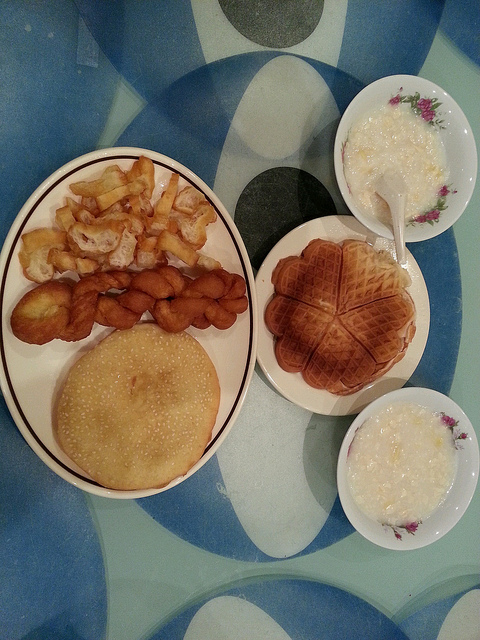


COCO Annotations (Bounding Boxes):
  - BBox: [x:0.0, y:1.08, w:480.0, h:628.45]
  - BBox: [x:375.16, y:168.14, w:32.41, h:94.56]
  - BBox: [x:332.37, y:74.73, w:145.86, h:168.69]
  - BBox: [x:335.48, y:387.11, w:144.22, h:165.1]
  - BBox: [x:50.75, y:326.94, w:169.78, h:166.85]

RefCOCOg Phrases:
  - 'bowl of grits or oatmeal with a white spoon in the bowl'
  - 'Food in bowl with spoon in it.'
  - 'Bowl of oatmeal without spoon'
  - 'A bowl of grits without a spoon'

Image ID: 402255
Image Name: COCO_train2014_000000402255.jpg


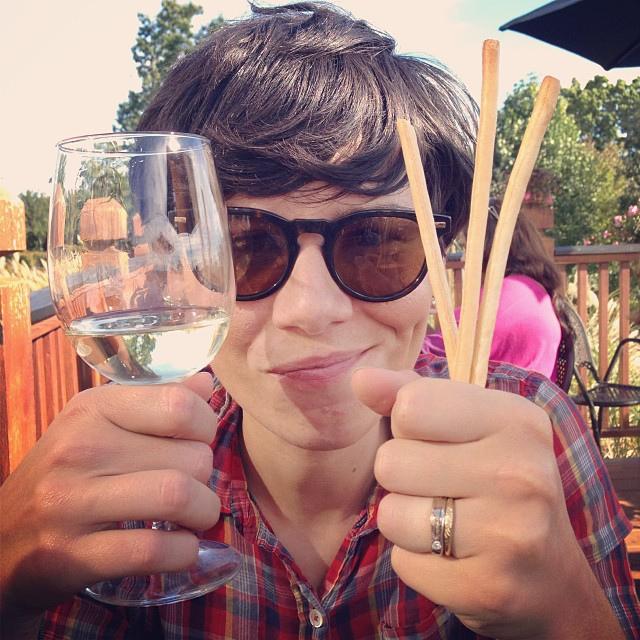


COCO Annotations (Bounding Boxes):
  - BBox: [x:559.88, y:301.26, w:80.12, h:201.73]
  - BBox: [x:569.09, y:338.56, w:70.91, h:68.67]
  - BBox: [x:1.44, y:1.44, w:638.56, h:631.37]
  - BBox: [x:48.9, y:133.75, w:201.35, h:471.73]
  - BBox: [x:497.87, y:0.0, w:142.13, h:72.5]
  - BBox: [x:547.38, y:324.58, w:26.67, h:69.79]
  - BBox: [x:427.0, y:200.6, w:144.42, h:177.06]

RefCOCOg Phrases:
  - 'A man holding a glass and bread.'
  - 'A woman with a cute pixie haircut holds up breadsticks and a glass of wine.'
  - 'person in pink shirt behind person in dark glasses'
  - 'A lady in pink behind the sticks'

Image ID: 466134
Image Name: COCO_train2014_000000466134.jpg


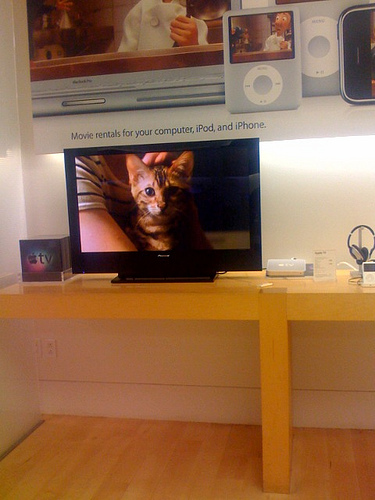


COCO Annotations (Bounding Boxes):
  - BBox: [x:62.92, y:136.03, w:202.25, h:139.33]
  - BBox: [x:125.29, y:152.35, w:91.92, h:99.34]
  - BBox: [x:77.15, y:149.77, w:67.96, h:101.71]
  - BBox: [x:116.97, y:0.0, w:90.52, h:51.51]
  - BBox: [x:26.39, y:0.0, w:217.34, h:117.15]

RefCOCOg Phrases:
  - 'a tv on a yellow table with a tabby cat on the screen'
  - 'The monitor on the table with a picture of an orange cat.'
  - 'The picture directly above the tv.'
  - 'The laptop displayed in the ad above the TV.'

Image ID: 80495
Image Name: COCO_train2014_000000080495.jpg


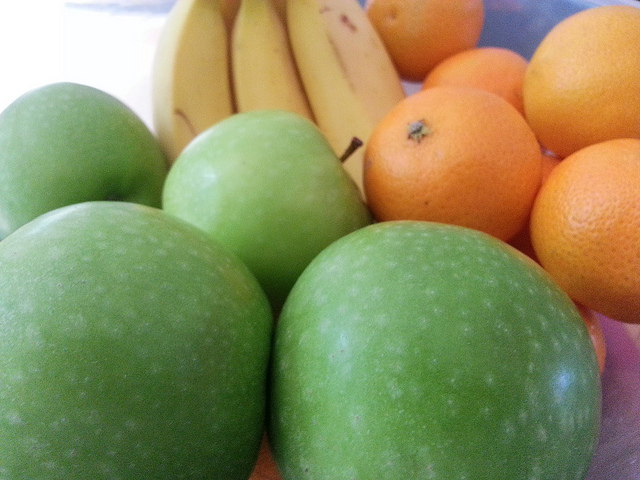


COCO Annotations (Bounding Boxes):
  - BBox: [x:284.82, y:0.85, w:122.56, h:203.12]
  - BBox: [x:138.92, y:1.91, w:182.96, h:161.51]
  - BBox: [x:360.56, y:83.38, w:185.92, h:158.87]
  - BBox: [x:531.95, y:134.4, w:108.05, h:201.04]
  - BBox: [x:521.65, y:5.31, w:118.35, h:156.0]
  - BBox: [x:424.79, y:43.41, w:105.7, h:77.18]
  - BBox: [x:365.85, y:0.0, w:121.91, h:84.03]
  - BBox: [x:159.64, y:106.79, w:207.1, h:186.6]
  - BBox: [x:584.07, y:316.06, w:22.07, h:53.05]
  - BBox: [x:3.5, y:83.33, w:166.23, h:144.86]
  - BBox: [x:0.34, y:201.0, w:275.82, h:279.0]
  - BBox: [x:247.14, y:412.73, w:38.92, h:66.64]
  - BBox: [x:270.23, y:216.26, w:330.7, h:256.65]

RefCOCOg Phrases:
  - 'fresh banana'
  - 'bananas in a fruit display'
  - 'A banana on the right of a bunch of bananas.'
  - 'a banann'
  - 'An apple behind three others.'
  - 'A green apple in the front left of a handful of apples.'
  - 'The bottom left most green apple'
  - 'the green apple to the right and closest'
  - 'The gr

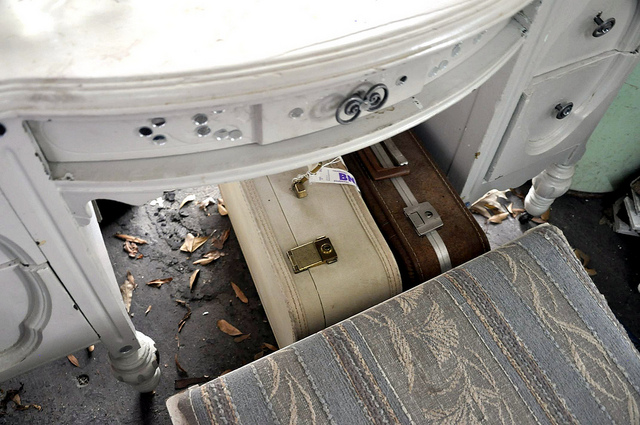


COCO Annotations (Bounding Boxes):
  - BBox: [x:341.72, y:129.22, w:148.37, h:161.77]
  - BBox: [x:218.71, y:158.54, w:188.14, h:192.92]
  - BBox: [x:175.0, y:229.55, w:459.09, h:188.63]

RefCOCOg Phrases:
  - 'SANDAL COLOR TRAVEL SUITCASE AND LOCKED'
  - 'A light tan suit case with a blue and white tag on it sitting under a desk.'
  - 'brown suitcase'
  - 'Brown suitcase.'



In [ ]:
import os
import random
import json
from IPython.display import Image, display

# 1. Define paths and load annotation files

image_folder = "my_dataset_2/train2014"
coco_ann_path = "my_dataset_2/annotations/instances_train.json"
refcoco_ann_path = "my_dataset_2/annotations/refcocog_train.json"

# Load COCO annotations (for bounding boxes)
with open(coco_ann_path, "r") as f:
    coco_data = json.load(f)

# Load RefCOCOg annotations (for phrases)
with open(refcoco_ann_path, "r") as f:
    refcoco_data = json.load(f)

# 2. Create lookup dictionaries

# Map image IDs to their filenames
id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Map image IDs to their COCO annotations
id_to_coco_anns = defaultdict(list)
for ann in coco_data['annotations']:
    id_to_coco_anns[ann['image_id']].append(ann)

# Map image IDs to their RefCOCOg phrases
id_to_refcoco_phrases = defaultdict(list)
for ann in refcoco_data:
    # Iterate through the list of sentences for each annotation
    for sentence in ann['sentences']:
        id_to_refcoco_phrases[ann['image_id']].append(sentence['raw'])

# 3. Display images, annotations, and phrases

if not os.path.exists(image_folder):
    print(f"Error: The folder '{image_folder}' does not exist.")
else:
    # Get a list of all image IDs with annotations
    annotated_image_ids = list(id_to_filename.keys())

    if not annotated_image_ids:
        print("Error: No images with annotations found.")
    else:
        # Select 5 random image IDs to display
        sample_image_ids = random.sample(annotated_image_ids, k=min(5, len(annotated_image_ids)))

        for image_id in sample_image_ids:
            image_name = id_to_filename[image_id]
            image_path = os.path.join(image_folder, image_name)

            print(f"====================================")
            print(f"Image ID: {image_id}")
            print(f"Image Name: {image_name}")
            display(Image(filename=image_path, width=400))

            # Print COCO annotations (bounding boxes)
            print("\nCOCO Annotations (Bounding Boxes):")
            for ann in id_to_coco_anns.get(image_id, []):
                bbox = ann['bbox']
                print(f"  - BBox: [x:{bbox[0]}, y:{bbox[1]}, w:{bbox[2]}, h:{bbox[3]}]")

            # Print RefCOCOg phrases
            print("\nRefCOCOg Phrases:")
            for phrase in id_to_refcoco_phrases.get(image_id, []):
                print(f"  - '{phrase}'")

            print("====================================\n")

In [ ]:

!zip -r my_dataset_2.zip my_dataset_2
files.download("my_dataset_2.zip")

  adding: my_dataset_2/ (stored 0%)
  adding: my_dataset_2/train2014/ (stored 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000066642.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000324332.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000406792.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000211540.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000561785.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000379539.jpg (deflated 1%)
  adding: my_dataset_2/train2014/COCO_train2014_000000522312.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000073190.jpg (deflated 5%)
  adding: my_dataset_2/train2014/COCO_train2014_000000062279.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000210271.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_000000222472.jpg (deflated 0%)
  adding: my_dataset_2/train2014/COCO_train2014_0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>